# <center> Newman on custom trace and user graph </center>

In [1]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [2]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [3]:
Author = util.get_authors(trace_path)

Get users.

In [4]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


In [8]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

449 0 19 295
450 0.021173416473272415 7 -1
451 0.7636555748719684 22 -1
452 0.7673483034352304 24 368
453 0.9666335887161412 23 353
454 1.1577495526710848 25 387


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [9]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. We set the number of observation N[i,j] to the number of retweets by j.

/!\ N[i,j] : nb obs for j-->i /!\

/!\ E[i,j] : nb edges observed for j-->i /!\

In [10]:
# init
E = {e:0 for e in node_pairs}
N = {e:0 for e in node_pairs}

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet
    if rtid != -1:
        
#         # update N[.,uid]
#         for user in users.difference({uid}):
#             N[uid, user] += 1
            
        # if retweetd user known update E[rtu,uid]
        if rtid in Author:
            rtu = Author[rtid]
            if rtu != uid: # no self-edges
                E[uid,rtu] = min(E[uid,rtu]+1, 16)
                
N = { e:16 for e in node_pairs}

Reduce the scale of N and E to avoid floats problems.

In [380]:
def scaling(x, I1, I2):
    # scales x from interval I1=[A,B] to I2=[a,b]
    A, B = I1[0], I1[1]
    a, b = I2[0], I2[1]
    return ((b-a)*x + a*B - A*b) / (B-A)

I1 = (min(E.values()), max(N.values()))
I2 = (2,4)
for e in N:
    N[e] = scaling(N[e], I1, I2)
    E[e] = scaling(E[e], I1, I2)
    
# # old scaling
# scaling_factor = min(E.values()) + 1
# for e in N:
#     N[e] /= scaling_factor
#     E[e] /= scaling_factor

In [11]:
print("min E, max E = ", min(E.values()), ",", max(E.values()))

min E, max E =  0 , 16


## 2. Iterations

Choose parameters.

In [80]:
repetitions = 1000
max_iter = 1000
verbose = False

Proceed.

In [81]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.random()
        a = random.random()
        b = random.random()
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in node_pairs:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])
            
            # update w,a,b
            w = sum(Q.values()) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in node_pairs:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution
            if np.all(np.abs([a-old_a, b-old_b, w-old_w]) < 0.0001):
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        continue

Print results.

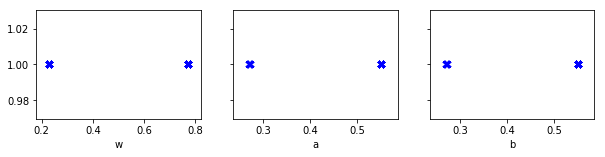

values for w and proportion
0.773 0.278
0.229 0.24
0.227 0.244
0.771 0.238

values for a and proportion
0.271 0.516
0.552 0.244
0.551 0.24

values for b and proportion
0.552 0.278
0.271 0.484
0.551 0.238

values for (w,a,b) and proportion
(0.773, 0.271, 0.552) 0.278
(0.227, 0.552, 0.271) 0.244
(0.771, 0.271, 0.551) 0.238
(0.229, 0.551, 0.271) 0.24


In [74]:
# plot the results
mean = dict()
med = dict()
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].scatter(values, [1]*len(values), marker='x', alpha=.5, linewidths=.01, color='blue', label=key)
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    for v in set(val):
        print(v, val.count(v)/len(val))
    print()
    
print("values for (w,a,b) and proportion")
val = list()
for i in range(len(results['w'])):
    val.append((round(results['w'][i],3), round(results['a'][i],3), round(results['b'][i],3)))
for v in set(val):
    print(v, val.count(v)/len(val))

Set w,a,b to the most observed values and compute Q accordingly.

In [75]:
w, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]
for (i,j) in node_pairs:
    Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
    Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

Text(0, 0.5, 'a posteriori edge proba')

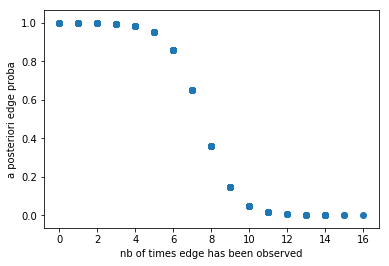

In [76]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = [E[e] for e in node_pairs]
y2plot = [Q[e] for e in node_pairs]
plt.scatter(x2plot, y2plot)
plt.xlabel("nb of times edge has been observed")
plt.ylabel("a posteriori edge proba")

Get real graph.

In [77]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

Compare edges in real graph vs their posterior probability.

Text(0, 0.5, 'nb of actual edges')

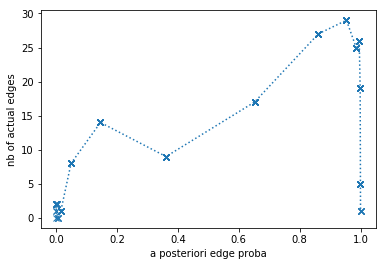

In [78]:
plt.rcParams["figure.figsize"] = [6,4]
real_edges_count = list()
for q in sorted(Q.values()):
    real_edges_count.append(0)
    for e in G.edges:
        if Q[e] == q:
            real_edges_count[-1] += 1
            
plt.plot(sorted(Q.values()), real_edges_count, marker='x', ls=':')
plt.xlabel("a posteriori edge proba")
plt.ylabel("nb of existing edges")

Text(0, 0.5, 'prop of actual existing edges')

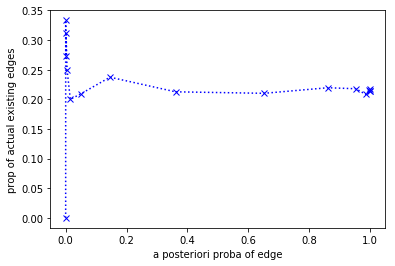

In [79]:
Qval = list(Q.values())
Qval_unique = sorted(set(Qval))
real_edge_prob = list()

for q in Qval_unique:
    real_edge_prob.append(len([e for e in G.edges if Q[e]<=q]) / len([e for e in Q if Q[e]<=q]))
#     print(q, real_edge_prob[-1])
    
plt.plot(Qval_unique, real_edge_prob, marker='x', ls=':', color='blue')
plt.xlabel("a posteriori proba of edge")
plt.ylabel("prop of actual existing edges")

Text(0, 0.5, 'Normalized prop')

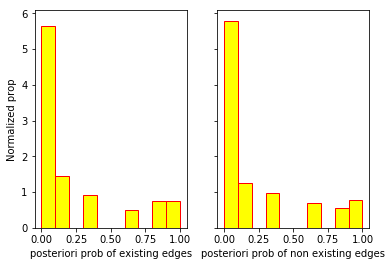

In [71]:
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].hist([Q[e] for e in G.edges], density=True, facecolor='yellow', edgecolor='red')
ax[0].set_xlabel("posteriori prob of existing edges")
ax[1].hist([Q[e] for e in node_pairs if e not in G.edges], density=True, facecolor='yellow', edgecolor='red')
ax[1].set_xlabel("posteriori prob of non existing edges")
ax[0].set_ylabel("Normalized prop")

Estimate $\omega$ from real graph and get real values of $a,b$.

In [58]:
w_estimated_from_real_graph = G.number_of_edges() / (2*binom(n,2))
print("estimated w from real graph = ", w_estimated_from_real_graph)

a_numerator, a_denominator = 0, 0
for e in G.edges:
    a_numerator += E[e]
    a_denominator += N[e]
print("real a = ", a_numerator/a_denominator)

b_numerator, b_denominator = 0, 0
for e in node_pairs:
    if e not in G.edges:
        b_numerator += E[e]
        b_denominator += N[e]
print("real b = ", b_numerator/b_denominator)

estimated w from real graph =  0.21379310344827587
real a =  0.3377016129032258
real b =  0.33415570175438597


Compare expected degrees.

In [59]:
print("Expected degree observed : {} with variance ={}".format(2*sum(Q.values())/n, "?"))
print("Real expected degree : ", np.mean(G.degree()))

Expected degree observed : 13.261182606861395 with variance =?
Real expected degree :  13.45


### 3.2 Sample generation

We generate a sample graph according to the posterior distribution.

Q[i,j] = proba of edge j-->i.

In [60]:
G_sample = nx.DiGraph()
G_sample.add_nodes_from(users)

for e in node_pairs:
    if random.random() < Q[e]:
        G_sample.add_edge(e[1], e[0])

Compare real graph with sample.

In [62]:
sampled_edges_in_real = set()
real_edges_in_sample = set()

for e in G_sample.edges:
    if e in G.edges:
        sampled_edges_in_real.add(e)

for e in G.edges:
    if e in G_sample.edges:
        real_edges_in_sample.add(e)
        
print("Proportion of edges from real graph in sample : ", len(real_edges_in_sample)/G.number_of_edges())
print("Proportion of edges from sample in real graph : ", len(sampled_edges_in_real)/G_sample.number_of_edges())

Proportion of edges from real graph in sample :  0.23655913978494625
Proportion of edges from sample in real graph :  0.21256038647342995
